# **Primeras clasificaciones y transformaciones**



* **Con la necesidad de generar el menor impacto en las oportunidades generadas en términos nominales y porcentuales sobre una cantidad total determinada de datos recibidos.**

* El objetivo primordial del modelo es optimizar la eficiencia en el uso del tiempo consultor. Además definiendo prioridades es posible brindar una atención mas inmediata y personalizada cuando sea oportuno. 



* Carga de data (excel descargado de hubspot
* Analisis y transformación prelimiar
* Limpieza y entrada de campos vacios

In [1]:
import numpy as np 
import pandas as pd 
import os
df = pd.read_excel("C:\\Users\\Electro-PC\\Python\\FQC_HUBSPOT\\copy_leads_FQC_hubspot.xlsx")

print(df.head(5))
print(df.describe(include='all').head(5))

            Nombre  Apellido       Pais  \
0            May 👋         👋         --   
1     Vista previa       NaN        NaN   
2  Julián Zubeldia  Zubeldia  Argentina   
3     Vista previa       NaN        NaN   
4               MZ       NaN        NaN   

                                  Zona Horaria Provincia  Localidad  \
0       UTC -03:00 América Argentina (Mendoza)         --        --   
1                                          NaN        NaN       NaN   
2  UTC -03:00 América Argentina (Buenos Aires)         --     lanus   
3                                          NaN        NaN       NaN   
4                                          NaN        NaN       NaN   

           Zona  Ciudad IP  Estado actual del lead Fuente  ...  \
0            --  san martin   Capital insuficiente     --  ...   
1           NaN         NaN                    NaN    NaN  ...   
2  Buenos Aires       lanus       No va a invertir     --  ...   
3           NaN         NaN                    NaN

* Es nesario limpiar la data que nos dio hubspot, primero eliminaremos las filas que contienen las iniciales y  "vista previa" en la columnna Nombre.

* Ademas, eliminamos todos los campos NaN debido a que el campo vacio por defecto en hubspot es "--".

* Ademas, modificamos los tipos de datos y convertimos los valores str en minuscula y los numericos en float.

In [2]:
df = df[(df['Nombre'].str.len() > 2) & (df['Nombre'] != 'Vista previa') ]
df = df.dropna(subset=['Apellido'])
df = df.astype(str)
df = df.applymap(lambda s:s.lower().strip() if type(s) == str else s)
columnas_int = ['Visitas a la pagina', 'formularios enviados', 'Interacciones varias', 'Aperturas de correo']
for columna in columnas_int:
    df[columna] = df[columna].astype(float)  
    
# Elimino las columnas que no aportan al modelo ni al analisis.
df = df.drop(['Nombre','Apellido','correo','Mensaje','Comentario', 'numero ', 'Zona Horaria', 'Pais'], axis=1)

# Convertir todas las etiquetas de las columnas a minúsculas y eliminar los espacios en blanco al principio y al final
df.columns = df.columns.str.lower().str.strip()

# Renombrar la columna 'elead' a 'c_objetivo'
df = df.rename(columns={'estado actual del lead': 'c_objetivo'})

# Ver las primeras filas del dataframe
df.head()




,provincia,localidad,zona,ciudad ip,c_objetivo,fuente,fuente ultima,fuente original,formularios enviados,visitas a la pagina,interacciones varias,aperturas de correo,franquicia,inversion
0,--,--,--,san martin,capital insuficiente,--,fuentes sin conexión,fuentes sin conexión,0.0,0.0,0.0,0.0,guapaletas,nan
2,--,lanus,buenos aires,lanus,no va a invertir,--,búsqueda de pago,búsqueda de pago,1.0,1.0,1.0,1.0,la birra bar,--
5,--,buenos aires,--,tortuguitas,capital insuficiente,--,búsqueda orgánica,búsqueda orgánica,1.0,1.0,0.0,0.0,don us company,--
8,--,salta,cerrillos,--,mala calidad,formulario,redes sociales de pago,redes sociales de pago,1.0,1.0,0.0,0.0,guapaletas,--
11,entre ríos,rosario del tala,--,rosario del tala,no va a invertir,--,tráfico directo,fuentes sin conexión,0.0,0.0,6.0,2.0,alma rural,--


In [3]:
cant_distintos = df.agg(pd.Series.nunique)
valores_unicos = {col: df[col].unique() for col in df.columns}

print("Cantidad de valores distintos en cada columna:")
print(cant_distintos)

Cantidad de valores distintos en cada columna:
provincia                19
localidad               318
zona                    149
ciudad ip               191
c_objetivo               13
fuente                   14
fuente ultima             9
fuente original           8
formularios enviados      8
visitas a la pagina       6
interacciones varias     15
aperturas de correo       8
franquicia              110
inversion                 2
dtype: int64


* **Ahora, intentare clasificar, transformar y reducir al maximo las columnas de valores que se utilizaran en el entrenamiento.**


# **COLUMNAS VARIABLES**

# 
* **Columna Variable**
/zona_unificada (Ubicacion geografica del dato)


* Decidí incluir las columnas en el conjunto: "País, Provincia, Localidad, Zona, Ciudad IP". Debido a los campos vacíos, el objetivo es consolidar la información en 1 columna. 
* A priori, la variable de ubicación de un prospecto es relevante; no obstante, la data esta muy sucia y analizaremos su incorporacion al modelo y bajo que terminos

<Axes: >

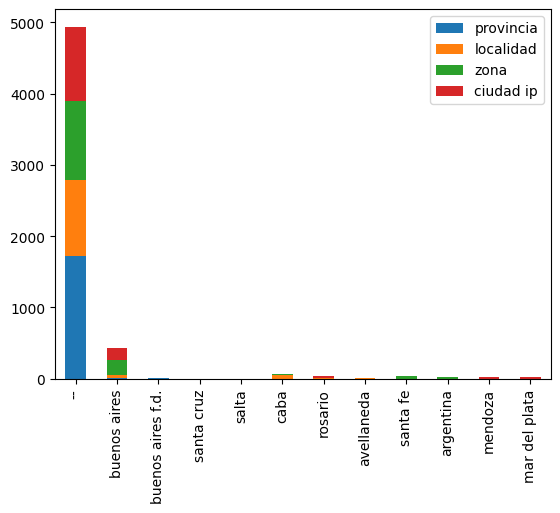

In [4]:
top_a = df['provincia'].value_counts().head(5)
top_b = df['localidad'].value_counts().head(5)
top_c = df['zona'].value_counts().head(5)
top_d = df['ciudad ip'].value_counts().head(5)
df_top_valores = pd.concat([top_a, top_b, top_c, top_d], axis=1)

df_top_valores.plot(kind='bar', stacked=True)

* Mayoria "--" (Campos vacios)
* Intentare seleccionar el primer valor válido (si hubiere) de cada fila en las columnas, definiendo las prioridades de general a particular(provincia a Localidad), 
* Unificando las columnas respectivas a la ubicacion en la nueva columna "zonas_unificadas" y dejar los entrys sin valor en la columna "sin valor"

In [5]:
def seleccionar_valor(row, columnas):
    for col in columnas:
        valor = row[col]
        if not pd.isna(valor) and str(valor) != 'nan' and str(valor) != '--':
            return valor
    return 'sin valor'

columnas = ['provincia', 'zona', 'ciudad ip', 'localidad']
df['zonas_unificadas'] = df.apply(lambda row: seleccionar_valor(row, columnas), axis=1)
top_20_zonas = df['zonas_unificadas'].value_counts().head(20)

import plotly.graph_objects as go
import plotly.express as px
fig_bar = px.bar(x=top_20_zonas.index, y=top_20_zonas, labels={'x': 'Zonas', 'y': 'Frecuencia'}, title='Top 20 zonas más frecuentes en zonas_unificadas')
fig_bar.show()

In [6]:
#Ahora que tenemos 'zona_f' elimino el resto de columnas pertinentes a este area
df = df.drop(['provincia', 'zona', 'ciudad ip', 'localidad'], axis=1)

# Función para unificar los nombres de las zonas Cuando contengan terminos pertinentes a Provincias que suelen aparecer repetidas.

def unificar_nombre_zona(zonas_unificadas):
    if isinstance(zonas_unificadas , str):
        if any(substring in zonas_unificadas for substring in ['aires', 'buenos', 'caba', 'capital federal', 'la matanza', 'san justo', 'quilmes', 'san martin']):
            return 'buenos aires'
        elif 'santa ' in zonas_unificadas or 'rosario' in zonas_unificadas.lower():
            return 'santa fe'
        elif 'posadas' in zonas_unificadas.lower():
            return 'mendoza'
        else:
            return zonas_unificadas
    else:
        return zonas_unificadas
# Aplicar la función unificar_nombre_zona() a cada valor de la columna 'zonas_unificadas'
df['zonas_unificadas'] = df['zonas_unificadas'].apply(unificar_nombre_zona)

# Verificar el resultado
zf = df['zonas_unificadas'].value_counts().head(18)

fig_pie = px.pie(values=zf, names=zf.index, title="zonas_unificadas")
fig_pie.show()

* Exeptuando Buenos Aires, el resto de Provincias no contienen valores suficientes para aportar al modelo. 
* Considerando la relevancia de otras columnas en el conjunto de datos prefiero evitar sesgar al modelo inecesariamente, por lo cual dividire a zona_f en 3 valores.


In [7]:
top_3_zonas = df['zonas_unificadas'].value_counts().head(2).index

def agrupar_otras(valores, top3_zonas):
    if valores not in top3_zonas:
        return "zonas menos recurrentes"
    else:
        return valores
    
df['zonas_unificadas'] = df['zonas_unificadas'].apply(lambda x: agrupar_otras(x, top_3_zonas))

# Verificar el resultado
zf = df['zonas_unificadas'].value_counts()

fig_pie = px.pie(values=zf, names=zf.index, title="zonas_unificadas")
fig_pie.show()

* Considero concluida la variable de ubicacion geografica 
* Mas adelante verificare la relacion frente a otras columnas y fundamentalmente frente a la columna objetivo


# 
* **Columna Variable**/fuente_unificada (Fuente)


* Nuevamente, unificaremos los valores intentando tomar "Fuente Original" de prioridad en este caso, reducir e incluso identificar y renombrar los -- sera mucho mas facil+


<Axes: >

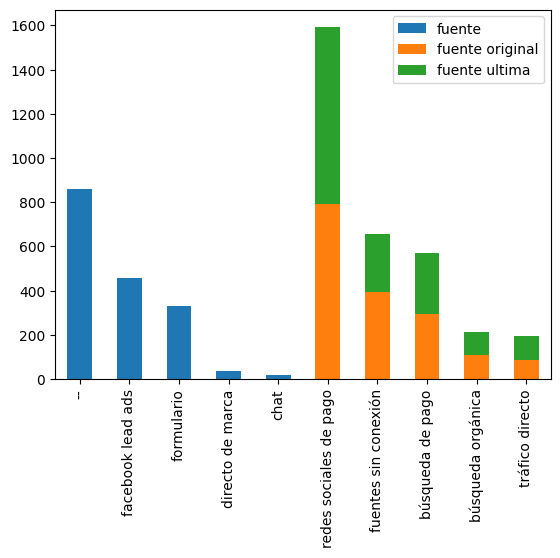

In [8]:
top_Fuente = df['fuente'].value_counts().head(5)
top_FuenteO = df['fuente original'].value_counts().head(5)
top_FuenteU = df['fuente ultima'].value_counts().head(5)
df_top_valores = pd.concat([top_Fuente, top_FuenteO, top_FuenteU], axis=1)

df_top_valores.plot(kind='bar', stacked=True)

In [9]:
def seleccionar_valor(row, columnas):
    for col in columnas:
        valor = row[col]
        if not pd.isna(valor) and str(valor) != 'nan' and str(valor) != '--':
            return valor

columnas = ['fuente original', 'fuente ultima', 'fuente']
df['fuente_unificada'] = df.apply(lambda row: seleccionar_valor(row, columnas), axis=1)

# Verificar el resultado
print(df['fuente_unificada'].head())

0       fuentes sin conexión
2           búsqueda de pago
5          búsqueda orgánica
8     redes sociales de pago
11      fuentes sin conexión
Name: fuente_unificada, dtype: object


In [10]:
top_10fuentes = df['fuente_unificada'].value_counts().head(10)

import plotly.graph_objects as go
import plotly.express as px
fig_bar = px.bar(x=top_10fuentes.index, y=top_10fuentes, labels={'x': 'fuente_unificada', 'y': 'Frecuencia'}, title='Top 10 fuentes más frecuentes en fuente_unif')
fig_bar.show()

In [11]:
# Elimino las columnas excedentes relacionadas a la fuente 
df = df.drop(['fuente original', 'fuente ultima', 'fuente'], axis=1)
print(df.head())

              c_objetivo  formularios enviados  visitas a la pagina  \
0   capital insuficiente                   0.0                  0.0   
2       no va a invertir                   1.0                  1.0   
5   capital insuficiente                   1.0                  1.0   
8           mala calidad                   1.0                  1.0   
11      no va a invertir                   0.0                  0.0   

    interacciones varias  aperturas de correo      franquicia inversion  \
0                    0.0                  0.0      guapaletas       nan   
2                    1.0                  1.0    la birra bar        --   
5                    0.0                  0.0  don us company        --   
8                    0.0                  0.0      guapaletas        --   
11                   6.0                  2.0      alma rural        --   

           zonas_unificadas        fuente_unificada  
0              buenos aires    fuentes sin conexión  
2             

# 
* **Columna Variable**/inversion (ticket)



* La columna Inversion decidi dejarla a pesar de contener valores vacios, ya que puedo completarlos utilizando como referencia la columna "Franquicia"**



In [12]:
usd25mil = ['befruit', 'dulce hora', 'don antonio', 'central de pizzas y empanadas', 'big pizza']
usd60mil = ['pirka', 'guapaletas', 'don us company', 'quecrecen ar','le panem','vitalcer ', 'neo zoo', 'sanduba', 'el mundo del mueble', 'depi4ever', 'by papa', 'ferreterías h30', 'alma rural', 'all in express']
usd125mil = ['tienda de cafe', 'cafe martinez', 'cremolatti']
usd250mil = ['tostado', 'la birra bar', 'atalaya']


* Decido mantener la columna Monto de inversion como categorica, las numericas actuales corresponden a formas de interaccion, por lo cual podemos apreciar

* cierto orden en la clasificacion por escala. Si bien ulizare un Random Forest en principio, entiendo que es positivo modelar los datos de este modo.

In [13]:

def asignar_inversion(franquicia):
    for f in franquicia.split(","): 
        f = f.strip() 
        if f in usd25mil:
            return 'low'
        elif f in usd60mil:
            return 'med'
        elif f in usd125mil:
            return 'high'
        elif f in usd250mil:
            return 'veryhigh'
    return 'Otro'
df['inversion'] = df['franquicia'].apply(asignar_inversion)
print(df.head())

              c_objetivo  formularios enviados  visitas a la pagina  \
0   capital insuficiente                   0.0                  0.0   
2       no va a invertir                   1.0                  1.0   
5   capital insuficiente                   1.0                  1.0   
8           mala calidad                   1.0                  1.0   
11      no va a invertir                   0.0                  0.0   

    interacciones varias  aperturas de correo      franquicia inversion  \
0                    0.0                  0.0      guapaletas       med   
2                    1.0                  1.0    la birra bar  veryhigh   
5                    0.0                  0.0  don us company       med   
8                    0.0                  0.0      guapaletas       med   
11                   6.0                  2.0      alma rural       med   

           zonas_unificadas        fuente_unificada  
0              buenos aires    fuentes sin conexión  
2             

# 
* **Columna Variable**/Franquicia
 


In [14]:
#Encontramos las 25 Franquicias que mas aparecen
df['franquicia'] = df['franquicia'].str.split(',').str[0]

conteo = df['franquicia'].value_counts().head(35)


fig_bar = px.bar(x=conteo.index, y=conteo, labels={'x': 'franquicias', 'y': 'Cantidad de leads recibidos'}, title=' Leads recibido x Franquicias')
fig_bar.show()

* **El 94% de los valores en la columna estan concentrados en estas Franquicias, seran las utilizadas para el modelo y las demas las dejare en 'otras'**


NameError: name 'sns' is not defined

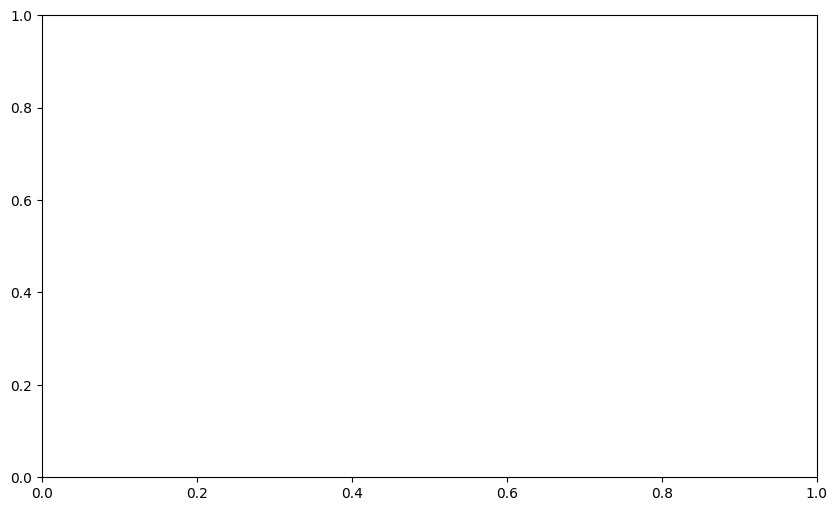

In [15]:


import matplotlib.pyplot as plt
conteos = df['franquicia'].value_counts()
porcentaje_acumulado = conteos.cumsum() / conteos.sum()
umbral = porcentaje_acumulado[porcentaje_acumulado <= 0.94].shape[0]

# Encontrar las franquicias más comunes
franquicias_mas_comunes = conteos.index[:umbral]

# Reemplazar las franquicias que no están en las más comunes por 'Otras'
df['franquicia'] = df['franquicia'].where(df['franquicia'].isin(franquicias_mas_comunes), 'otras')

conteos = df['franquicia'].value_counts()



# Comprobar resultado 
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x=conteos.index, y=conteos.values, ax=ax)
ax.set_title('Franquicias que componen el 94% de los datos recibidos + otras')
ax.set_xlabel('franquicias')
ax.set_ylabel('Leads recibidos')
plt.xticks(rotation=90)

plt.show()

# 
* **Columna Variablenumericas**/
'formularios enviados', 'visitas a la pagina', 'interacciones varias' , 'aperturas de correo'

* Estas columnas seran las unicas incorporadas al modelo como numericas
* Miden diversas interacciones y pueden ser muy utiles para los modelos que categorizan en funcion del orden natural de sus columnas numericas.
* Primero certifico que no existan relaciones muy elevadas entre las columnas

<Axes: >

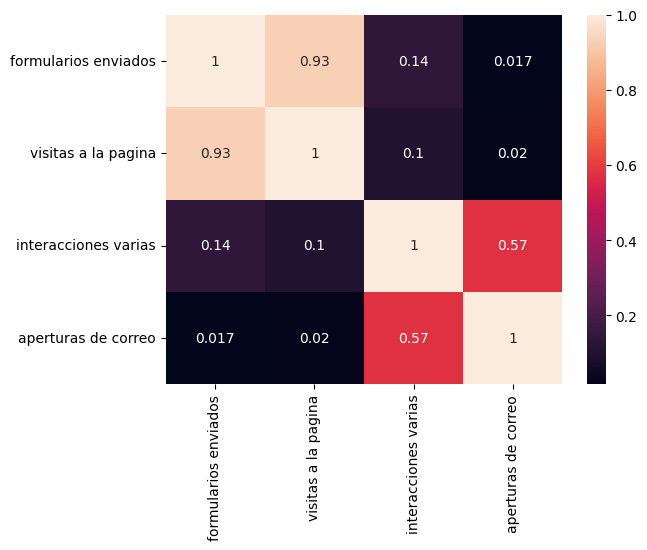

In [ ]:
import seaborn as sns
# Primero calculamos la matriz de correlación
correlation_matrix = df[['formularios enviados', 'visitas a la pagina', 'interacciones varias' , 'aperturas de correo']].corr()

sns.heatmap(correlation_matrix, annot=True)


In [ ]:
import plotly.express as px

df_avg = df.groupby('c_objetivo')[['visitas a la pagina', 'formularios enviados']].mean().reset_index()

fig = px.scatter(df_avg, x="visitas a la pagina", y="formularios enviados",
	         size="visitas a la pagina", color="c_objetivo",
                 hover_name="c_objetivo", log_x=True, size_max=60)
fig.show()

* **Visitas a la pagina es una instancia previa en el embudo de ventas y tiene una correlacion significativa con envios de formularios**.

* **A pesar de las similitudes son instancias diferentes y considero relevante diferenciarlas en el modelo**.

# **Columna Objetivo**

*  Debido a que una cantidad mayor de clases en la columna objetivo puede requerir mayor dificultad al entrenar cualquier modelo y sobre todo una gran cantidad de datos
*  La columna objetivo sera de clase binaria, agrupadas de la siguiente manera:
*  Primero, contamos la cantidad de valores únicos en columna 'ELEAD'

In [ ]:
eleadcount = df['c_objetivo'].value_counts().head(20)
import plotly.graph_objects as go
import plotly.express as px
fig_bar = px.bar(x=eleadcount.index, y=eleadcount, labels={'x': 'c_objetivo', 'y': 'Frecuencia'}, title='Distribucion de valores Columna Objetivo (c_objetivo)')
fig_bar.show()

* **Preparando la data para el modelo defino las clases en en binarias separando ambas en "leads_calificados" y "leads_perdidos"

* Guardo la actual en c_objetivo_multiclases para tener la version completa en futuras comparaciones


In [ ]:
def crear_clase_binaria (valor):
    
    leads_calificados = ['en seguimiento', 'calificado para la compra', 'clientes']
    leads_perdidos = ['capital insuficiente', 'mala calidad', 'imposible de contactar','no solicito información', 'aun sin respuesta', 'intentando contacto', 'no va a invertir', 'crowdfunding', 'formulario', 'remarketing']
       
    if valor in leads_calificados:
        return 'leads_calificados'
    elif valor in  leads_perdidos:
        return 'leads_perdidos'
    else:
        return np.nan

#Guardo c_objetivo en c_objetivo_multiclases para tener la version completa
df['c_objetivo_multiclases'] = df['c_objetivo']

print ('c_objetivo en clases multiples')
print (df['c_objetivo_multiclases'].value_counts().head(12))


df['c_objetivo'] = df['c_objetivo'].apply(crear_clase_binaria)

df = df.dropna(subset=['c_objetivo'])

print ('c_objetivo en clases binarias, a usar en el modelo ')
print (df['c_objetivo'].value_counts())

c_objetivo en clases multiples
no va a invertir             559
capital insuficiente         463
imposible de contactar       309
en seguimiento               139
mala calidad                 122
no solicito información       55
calificado para la compra     46
intentando contacto           26
zona no disponible            20
clientes                       6
crowdfunding                   2
--                             2
Name: c_objetivo_multiclases, dtype: int64
c_objetivo en clases binarias, a usar en el modelo 
leads_perdidos       1537
leads_calificados     191
Name: c_objetivo, dtype: int64


* La diferencia entre los valores de cada clase es muy alta, es propio del negocio y el tipo de venta y puede ser un desafio en el modelo de predicción.
* Utilizare SMOTE como tecnica de sobremuestreo de la clase inferior para evitar desequilibrios

# 
* **Relacion entre Columnas Variables y Columna OBJETIVO c_objetivo**

* **Mapa de calor utilizando la funcion Cramers_v para relacionar datos de una forma mas compleja.**


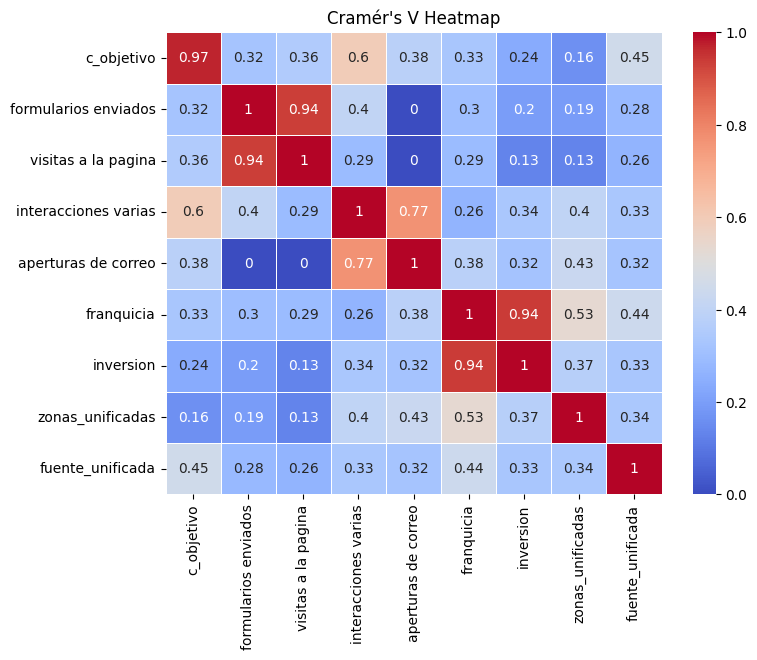

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


columns_of_interest = ['c_objetivo','formularios enviados', 'visitas a la pagina', 'interacciones varias', 'aperturas de correo', 'franquicia', 'inversion', 'zonas_unificadas', 'fuente_unificada']
df_selected = df[columns_of_interest]


df_sample = df_selected.sample(frac=0.1, random_state=31)


cramers_v_matrix = pd.DataFrame(index=columns_of_interest, columns=columns_of_interest)

for col1 in columns_of_interest:
    for col2 in columns_of_interest:
        cramers_v_matrix.loc[col1, col2] = cramers_v(df_sample[col1], df_sample[col2])


cramers_v_matrix = cramers_v_matrix.astype(float)


plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Cramér's V Heatmap")
plt.show()

* **Es interesante notar que interacciones varias y fuente_unificada tienen una relacion considerablemente alta con la columna objetivo**
* Para comparar la columna "fuente_unificada" utilizare c_objetivo_multticlasees


In [ ]:
fig = go.Figure()
zonas_agrupadas = df.groupby(['c_objetivo_multiclases', 'fuente_unificada']).size().reset_index(name='conteo')

# Añado una barra para cada valor único de 'ELEAD'
for elead in zonas_agrupadas['c_objetivo_multiclases'].unique():
    zonas_elead = zonas_agrupadas[zonas_agrupadas['c_objetivo_multiclases'] == elead]
    # Asigna el color correcto a la traza
    fig.add_trace(go.Bar(x=zonas_elead['fuente_unificada'], y=zonas_elead['conteo'], name=str(elead)))

# Configuro el diseño del gráfico
fig.update_layout(barmode='stack', title='Relación entre fuente y c_objetivo',
                  xaxis_title='Fuente', yaxis_title='Cantidad de c_objetivo_multiclases')
fig.show()


* Lo mismo en las columnas numericas

In [ ]:
import plotly.express as px

df_avg = df.groupby('c_objetivo_multiclases')['visitas a la pagina', 'interacciones varias'].mean().reset_index()

fig = px.scatter(df_avg, x="interacciones varias", y="visitas a la pagina",
	         size="interacciones varias", color="c_objetivo_multiclases",
                 hover_name="c_objetivo_multiclases", log_x=True, size_max=60)
fig.show()

C:\Users\Electro-PC\AppData\Local\Temp\ipykernel_24984\1797451463.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
import plotly.express as px

df_avg = df.groupby('c_objetivo_multiclases')['visitas a la pagina', 'aperturas de correo'].mean().reset_index()

fig = px.scatter(df_avg, x="visitas a la pagina", y="aperturas de correo",
	         size="aperturas de correo", color="c_objetivo_multiclases",
                 hover_name="c_objetivo_multiclases", log_x=True, size_max=60)
fig.show()

C:\Users\Electro-PC\AppData\Local\Temp\ipykernel_24984\4026332156.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



* **Para las siguientes columnas categoricas, utilizaremos la columna objetivo de clases binaria.**

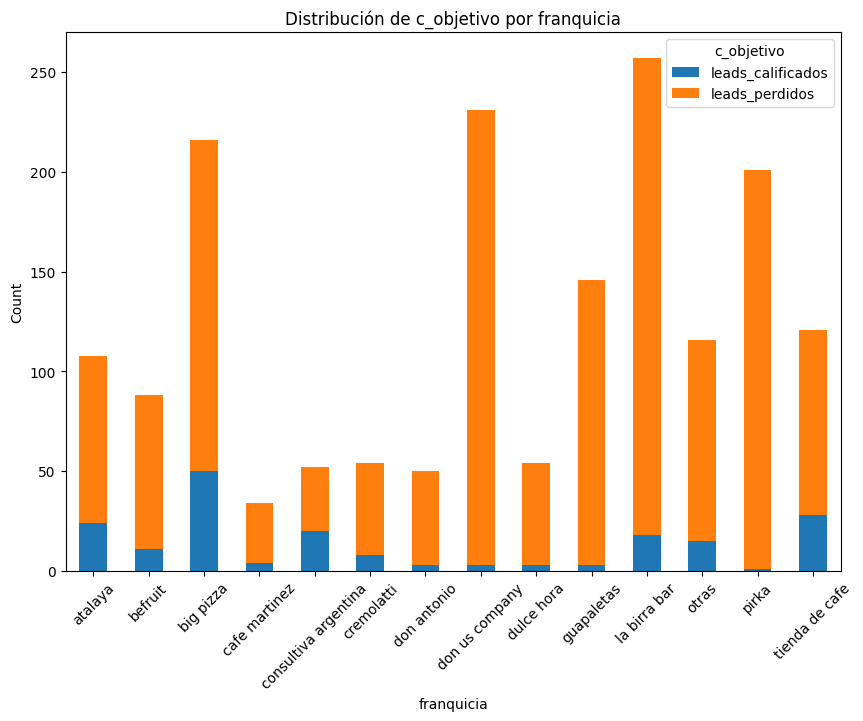

In [ ]:
import matplotlib.pyplot as plt

table = pd.crosstab(df['franquicia'], df['c_objetivo'])

# Crear gráfico de barras apilado
table.plot(kind='bar', stacked=True, figsize=(10,7))

plt.title('Distribución de c_objetivo por franquicia')
plt.xlabel('franquicia')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


* **c_ojetivo x zona**



In [ ]:

#colores = {'leads_calificados': '#90EE90 ', 'leads_perdidos': 'red'}

fig = go.Figure()
zonas_agrupadas = df.groupby(['c_objetivo', 'zonas_unificadas']).size().reset_index(name='conteo')

for elead in zonas_agrupadas['c_objetivo'].unique():
    zonas_elead = zonas_agrupadas[zonas_agrupadas['c_objetivo'] == elead]
    fig.add_trace(go.Bar(x=zonas_elead['zonas_unificadas'], y=zonas_elead['conteo'], name=str(elead)))

# diseño del gráfico
fig.update_layout(barmode='stack', title='Cantidad de leeds por segmento de zona',
                  xaxis_title='zonas_unificadas', yaxis_title='Cantidad de c_objetivo')

# Muestro el gráfico
fig.show()


# **MODELO**




* **Utilizare un modelo de random forest debido a la posibilidad de adaptarse bien a las columnas categoricas y numericas, clasificando sin demasiada atencion en la escala, ademas aplicare la tecnica de sobremuestre SMOTE para evitar desequilibrios de clases. Es importante notar que el 90% de los datos son leads_perdidos, por lo cual en este caso la predicción por la clase mayoritaria puede sesgar al modelo y proporcionar una gran precision a pesar de ser ineficaz.**


In [ ]:
df.iloc[10:15]

,c_objetivo,formularios enviados,visitas a la pagina,interacciones varias,aperturas de correo,franquicia,inversion,zonas_unificadas,fuente_unificada,c_objetivo_multiclases
29,leads_calificados,6.0,3.0,13.0,1.0,big pizza,low,buenos aires,referencias,clientes
32,leads_perdidos,1.0,1.0,3.0,3.0,dulce hora,low,buenos aires,redes sociales de pago,imposible de contactar
35,leads_perdidos,0.0,0.0,0.0,0.0,big pizza,low,buenos aires,fuentes sin conexión,imposible de contactar
38,leads_perdidos,1.0,1.0,0.0,0.0,tienda de cafe,high,sin valor,redes sociales de pago,imposible de contactar
41,leads_perdidos,1.0,1.0,3.0,3.0,la birra bar,veryhigh,buenos aires,redes sociales de pago,no va a invertir


In [ ]:
# Cargar y preparar los datos

data = df.drop(['c_objetivo_multiclases'], axis=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from scipy.stats import randint
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve


X = data.drop("c_objetivo", axis=1)
y = data["c_objetivo"]

# Definir los preprocesadores
numeric_features = ['formularios enviados', 'visitas a la pagina', 'interacciones varias' , 'aperturas de correo']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['franquicia', 'inversion', 'zonas_unificadas', 'fuente_unificada']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


clf = make_imb_pipeline(preprocessor, SMOTE(random_state=42), RandomForestClassifier())

# Definir  hiperparámetros a ajusta
param_dist = {
    'randomforestclassifier__n_estimators': randint(100, 500),
    'randomforestclassifier__max_depth': randint(1, 50),
    'randomforestclassifier__min_samples_split': randint(2, 10),
    'randomforestclassifier__min_samples_leaf': randint(1, 5)
}

# Definir la búsqueda aleatoria
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar el modelo a los datos de entrenamiento
random_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y usar el mejor modelo 
print(random_search.best_params_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)




print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

hl = hamming_loss(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print(f"Hamming Loss:{hl}")
print(f"Accuracy: {acc}")



Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'randomforestclassifier__max_depth': 21, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 413}
                   precision    recall  f1-score   support

leads_calificados       0.66      0.64      0.65        39
   leads_perdidos       0.95      0.96      0.96       307

         accuracy                           0.92       346
        macro avg       0.81      0.80      0.80       346
     weighted avg       0.92      0.92      0.92       346

[[ 25  14]
 [ 13 294]]
Hamming Loss:0.07803468208092486
Accuracy: 0.9219653179190751


# Resultado 1

In [ ]:
# Obtener las probabilidades de predicción
y_test_array = y_test.values
y_pred_tabla = best_model.predict_proba(X_test)

proba_df = pd.DataFrame(y_pred_tabla, columns=best_model.classes_)

proba_df['Prediction'] = y_pred
proba_df['Is Correct?'] = proba_df['Prediction'] == y_test_array

# Imprimir solo los primeros 34 resultados
print(proba_df.head(35))


    leads_calificados  leads_perdidos         Prediction  Is Correct?
0            0.246714        0.753286     leads_perdidos         True
1            0.184984        0.815016     leads_perdidos        False
2            0.002364        0.997636     leads_perdidos         True
3            0.000000        1.000000     leads_perdidos         True
4            0.000000        1.000000     leads_perdidos         True
5            0.160498        0.839502     leads_perdidos         True
6            0.000910        0.999090     leads_perdidos         True
7            0.008599        0.991401     leads_perdidos         True
8            0.741354        0.258646  leads_calificados         True
9            0.824224        0.175776  leads_calificados         True
10           0.003834        0.996166     leads_perdidos         True
11           0.902622        0.097378  leads_calificados        False
12           0.000000        1.000000     leads_perdidos         True
13           0.83259

# **RESULTADO FINAL**

**Finalmente, los falsos negativos se minimizaron considerablemente, reduciendo la precision pero permitiendo un modelo funcional, que optimiza los tiempos del consultor y permite brindar una atencion mas personalizada y atenta en los casos oportunos, el modelo fue testeado con 500 datos inicialmente y fue mejorando hasta recibir los 1800 actuales, considerando el desequilibrio de clases a predecir, una mayor cantidad de datos y una entrada mas completa de los campos podrian ser determinantes para optimizar e incluso automatizar primeras instancias de un ciclo de vida**

* En este caso, el modelo presenta fallas en la clase minoritaria "leads_calificados", a su vez la más relevante, probare distintos tipos de ubrales porcentuales para definir la predicción con el objetivo de minimizar al maximo los falsos "leads_perdidos", dado que resultan en costo de oportunidad. 

* **Con la necesidad de generar el menor impacto en las oportunidades generadas en términos nominales y porcentuales sobre una cantidad total determinada de datos recibidos.**

* El objetivo primordial del modelo es optimizar la eficiencia en el uso del tiempo consultor. Además definiendo prioridades es posible brindar una atención mas inmediata y personalizada cuando sea oportuno. 

In [ ]:
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Ajustar el umbral de clasificación en 82% de seguridad 
umbral = 0.82

# Clasificaciones basadas en el umbral ajustado
y_pred_adj = np.where(y_pred_prob > umbral, "leads_perdidos", "leads_calificados")

print(classification_report(y_test, y_pred_adj))
print(confusion_matrix(y_test, y_pred_adj))

hl = hamming_loss(y_test, y_pred_adj)
acc = accuracy_score(y_test, y_pred_adj)

print(f"Hamming Loss:{hl}")
print(f"Accuracy: {acc}")


                   precision    recall  f1-score   support

leads_calificados       0.38      0.85      0.53        39
   leads_perdidos       0.98      0.83      0.90       307

         accuracy                           0.83       346
        macro avg       0.68      0.84      0.71       346
     weighted avg       0.91      0.83      0.85       346

[[ 33   6]
 [ 53 254]]
Hamming Loss:0.17052023121387283
Accuracy: 0.8294797687861272


In [ ]:
# Obtener las probabilidades de predicción
y_test_array = y_test.values

y_pred_prob = best_model.predict_proba(X_test)
proba_df = pd.DataFrame(y_pred_prob, columns=best_model.classes_)
proba_df['Prediccion_nueva'] = y_pred_adj

proba_df['Resultado?'] = proba_df['Prediccion_nueva'] == y_test_array



print(proba_df.head(30))

    leads_calificados  leads_perdidos   Prediccion_nueva  Resultado?
0            0.246714        0.753286  leads_calificados       False
1            0.184984        0.815016  leads_calificados        True
2            0.002364        0.997636     leads_perdidos        True
3            0.000000        1.000000     leads_perdidos        True
4            0.000000        1.000000     leads_perdidos        True
5            0.160498        0.839502     leads_perdidos        True
6            0.000910        0.999090     leads_perdidos        True
7            0.008599        0.991401     leads_perdidos        True
8            0.741354        0.258646  leads_calificados        True
9            0.824224        0.175776  leads_calificados        True
10           0.003834        0.996166     leads_perdidos        True
11           0.902622        0.097378  leads_calificados       False
12           0.000000        1.000000     leads_perdidos        True
13           0.832593        0.167